## Exploration of feature selection robustness

We want to look at whether or not there are differences in how "robust" (i.e. stable/consistent between cross-validation folds and random seeds) the feature selection results for different selection methods are.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

### Load selected coefficients

In [2]:
# for this analysis we'll just look at the "all other cancers" results
pancancer_only_dir = os.path.join(
    'results', 'purity_binary_median', 'all_other_cancers'
)

In [3]:
all_coefs = []
for coefs_info, coefs_list in au.generate_coefficients_fs_purity(
        pancancer_only_dir, cfg.fs_methods, nonzero_only=False):
    for fold_no, coefs in enumerate(coefs_list):
        fold_info = coefs_info + [fold_no]
        all_coefs.append([fold_info, coefs])
        
print(len(all_coefs))

1320


In [4]:
print(len(all_coefs[0]))
print(all_coefs[0][0], all_coefs[0][1][:5])

2
['DLBC', 'mad', 1000, 1, 0] [('3512', -0.26612), ('714', -0.21247), ('712', -0.17399), ('7316', 0.17222), ('3133', -0.16511)]


### Get coefficient robustness info

Here, we want to look at how frequently each feature is selected. If a feature is selected almost every time across cancer types and cross-validation folds we'll consider it "robust", and if it's selected comparatively few times we'll consider it "not robust".

We'll just do this at the pan-cancer level for now -- not sure how best to summarize over individual cancer types.

In [5]:
# get pan-cancer feature selection frequency
# NOTE this is how frequently the feature was selected by
# the feature selection method, NOT how often it was actually
# used by the elastic net classifier
fs_method_coefs = {}
fs_method_denoms = {}
for coefs_info in all_coefs:
    identifier = '_'.join(
        [str(s) for s in coefs_info[0][1:3]]
    )
    coefs = coefs_info[1]
    fs_method_coefs[identifier] = (
        fs_method_coefs.get(identifier, {})
    )
    fs_method_denoms[identifier] = (
        fs_method_denoms.get(identifier, 0) + 1
    )
    for gene_coef in coefs:
        gene, coef = gene_coef
        # skip non-gene covariates
        if not gene.isdigit(): continue
        fs_method_coefs[identifier][gene] = (
            fs_method_coefs[identifier].get(gene, 0) + 1
        )
        
print(list(fs_method_coefs.keys()))

['mad_1000', 'median_f_test_250', 'random_250', 'pancan_f_test_250', 'mad_250']


In [6]:
print(list(fs_method_coefs['random_250'].keys())[:5])
print(np.unique(list(fs_method_coefs['random_250'].keys())).shape)

['56833', '3512', '187', '23306', '3561']
(6628,)


In [7]:
print(fs_method_denoms)

{'mad_1000': 264, 'median_f_test_250': 264, 'random_250': 264, 'pancan_f_test_250': 264, 'mad_250': 264}


In [8]:
display(fs_method_coefs['random_250']['10437'],
        fs_method_denoms['random_250'])

16

264

In [9]:
coefs_df = (
    pd.DataFrame(fs_method_coefs)
      .reset_index()
      .melt(id_vars='index', value_vars=fs_method_coefs.keys())
      .rename(columns={
          'index': 'gene',
          'variable': 'fs_method',
          'value': 'selected_count'
      })
      .dropna(subset=['selected_count'])
)
coefs_df['denom'] = coefs_df.fs_method.map(fs_method_denoms)
coefs_df['selected_prop'] = coefs_df.selected_count / coefs_df.denom

print(coefs_df.shape)
coefs_df.head()

(8655, 5)


,gene,fs_method,selected_count,denom,selected_prop
0,3512,mad_1000,264.0,264,1.0
1,714,mad_1000,264.0,264,1.0
2,712,mad_1000,264.0,264,1.0
3,7316,mad_1000,264.0,264,1.0
4,3133,mad_1000,264.0,264,1.0


In [10]:
# unique genes selected by each feature selection method
# across all 264 CV iterations
coefs_df.groupby('fs_method').count().loc[:, ['gene']]

,gene
fs_method,
mad_1000,1069
mad_250,277
median_f_test_250,300
pancan_f_test_250,381
random_250,6628


Text(0, 0.5, 'Number of features')

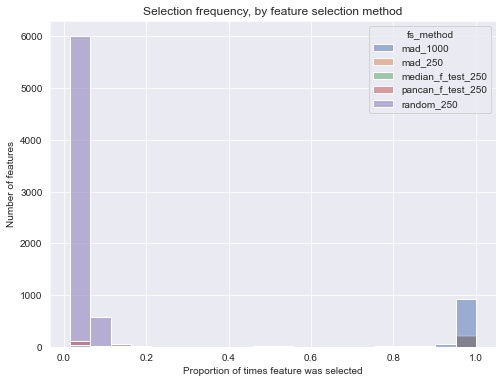

In [11]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(coefs_df, x='selected_prop', hue='fs_method',
             hue_order=np.sort(coefs_df.fs_method.unique()),
             bins=20)
plt.title('Selection frequency, by feature selection method')
plt.xlabel('Proportion of times feature was selected')
plt.ylabel('Number of features')

Text(0, 0.5, 'Number of features')

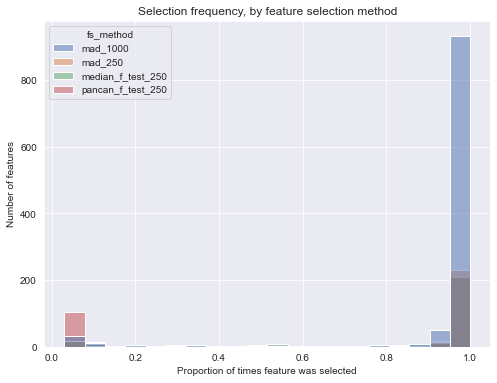

In [12]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(coefs_df[~(coefs_df.fs_method == 'random_250')],
             x='selected_prop', hue='fs_method',
             hue_order=np.sort(coefs_df.fs_method.unique())[:-1],
             bins=20)
plt.title('Selection frequency, by feature selection method')
plt.xlabel('Proportion of times feature was selected')
plt.ylabel('Number of features')

So here, we can see that the random feature selection is the least "robust" (most unique genes selected), which makes sense since it selects a new random set of genes per CV fold.

The other methods are much more robust (fewer unique genes selected), which makes sense since they are dependent on the data which shouldn't change that much between CV folds in the pan-cancer case. However, we can also see that better robustness doesn't necessarily correspond to better performance: `mad_250` is the most robust in terms of consistency between folds, but it performs worse in terms of AUPR/AUROC than the f-test methods. 